# Отток клиентов

Из банка постепенно уходят клиенты. По данным маркетологов, удержание нынешних клиентов выгоднее, чем привлечение новых. Компания хочет распознавать пользователей, которые скоро уйдут.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
#импортируем нужные библиотеки, отключаем предупреждения

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

In [2]:
#изучаем данные
data = pd.read_csv('/datasets/Churn.csv')
data.info()
display(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


**Выводы**

1) Столбец `Tenure` содержит пропуски, с ними модель не обучить.

2) Столбцы `RowNumber`, `CustomerId` и `Surname` не важны для исследования, но компьютер может их использовать при построении модели. Поэтому их нужно удалить.

3) Нужно разбить данные на 3 выборки: обучающую, валидационную и тестовую в соотношении 3:1:1.

4) В каждой выборке нужно выделить целевой и остальные признаки.

5) Столбцы `CreditScore`, `Age`, `Tenure`, `Balance`, `NumOfProducts`, `EstimatedSalary` содержат количественные значения. Для равного учета всех признаков нужно их масштабировать.

6) Столбцы `Geography`, `Gender`  состоят из качественных значений, поэтому нужно получить dummy-столбцы на их основе.

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: Tenure, dtype: float64


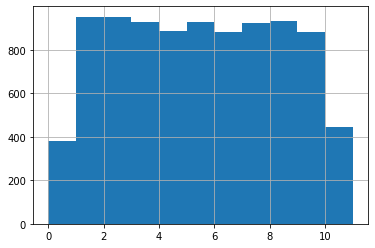

In [3]:
#исследуем значения в столбце и заполняем пропуски

data['Tenure'].hist(range=(0,11), bins=11)
print(data['Tenure'].describe())
data['Tenure'] = data['Tenure'].fillna(data['Tenure'].median())

Значения в столбце варьируются от 0 до 10 со средним и медианой 5. По форме распределение симметрично и близко к плато. Чтобы не терять 10% данных, заменим пропуски на медиану.

In [4]:
#удаляем ненужные столбцы, получаем dummy-столбцы
data = data.drop(['RowNumber', 'CustomerId','Surname'], axis=1)
data_ohe = pd.get_dummies(data, drop_first=True)
data_ohe.info()
display(data_ohe)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  float64
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_Germany  10000 non-null  uint8  
 10  Geography_Spain    10000 non-null  uint8  
 11  Gender_Male        10000 non-null  uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5.0,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10.0,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7.0,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3.0,75075.31,2,1,0,92888.52,1,1,0,1


In [5]:
#выделяем целевой признак и остальные, разбиваем данные на выборки
features = data_ohe.drop(['Exited'], axis=1)
target = data_ohe['Exited']
features_train, features_valid_test, target_train, target_valid_test = train_test_split(features, target,
                                                                                        test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid_test, target_valid_test,
                                                                                        test_size=0.5, random_state=12345)
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(6000, 11)
(6000,)
(2000, 11)
(2000,)
(2000, 11)
(2000,)


In [7]:
#масштабируем количественные признаки
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

## Исследование задачи

In [8]:
#изучаем баланс в целевом признаке
data['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

Доля покинувших равна примерно 20% от всех клиентов. Данные несбалансированы.

### Модель решающего дерева

In [9]:
best_f1 = 0
best_depth = 0
best_model = None
for depth in range (1,101,1):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    prediction_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, prediction_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_depth = depth
        best_model = model
probabilities = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities[:,1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(best_depth)
print(best_f1)

6
0.5696969696969697


 F1 равно 0.5696969696969697 при глубине 6
AUC-ROC лучшей модели: 0.8164631712023421


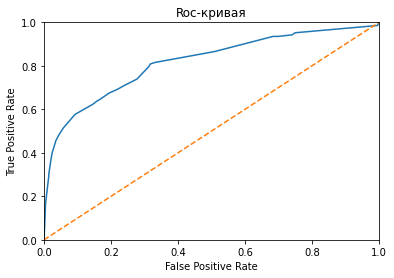

CPU times: user 112 ms, sys: 7.94 ms, total: 120 ms
Wall time: 125 ms


In [10]:

%%time

#обучаем модель с оптимальными гиперпараметрами

model = DecisionTreeClassifier(max_depth=6, random_state=12345)
model.fit(features_train, target_train)
prediction_valid = model.predict(features_valid)  
#исследуем метрики
f1 = f1_score(target_valid, prediction_valid)
print(f' F1 равно {f1} при глубине {best_depth}')
probabilities = model.predict_proba(features_valid)
probabilities_one_valid = probabilities[:,1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'AUC-ROC лучшей модели: {auc_roc}')

frp, trp, thresholds = roc_curve(target_valid,probabilities_one_valid)
plt.figure()
plt.plot(frp, trp)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc-кривая')
plt.plot([0,1], [0,1], linestyle='--')
plt.show()

### Модель случайного леса

In [11]:
best_model = None
best_f1 = 0
best_est = 0
best_depth = 0
for depth in range (1,11,1):
     for est in range(1,51,1):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345)
        model.fit(features_train, target_train)
        prediction_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, prediction_valid)
        if f1 > best_f1:
            best_f1 = f1
            best_est = est
            best_depth = depth
            best_model = model
print(f'Лучшее значение F1 равно {best_f1} при количестве деревьев {best_est} и глубине {best_depth}')
probabilities = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities[:,1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'AUC-ROC лучшей модели: {auc_roc}')

Лучшее значение F1 равно 0.5924812030075188 при количестве деревьев 11 и глубине 10
AUC-ROC лучшей модели: 0.84822146879669


Значение F1 равно 0.5924812030075188
AUC-ROC модели: 0.84822146879669


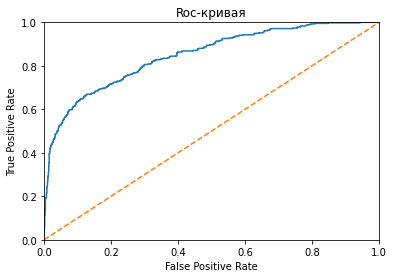

CPU times: user 223 ms, sys: 12.1 ms, total: 235 ms
Wall time: 242 ms


In [12]:
%%time

#обучаем модель
model = RandomForestClassifier(n_estimators=11, max_depth=10, random_state=12345)
model.fit(features_train, target_train)
prediction_valid = model.predict(features_valid)
#исследуем метрики
f1 = f1_score(target_valid, prediction_valid)
print(f'Значение F1 равно {f1}')
probabilities = model.predict_proba(features_valid)
probabilities_one_valid = probabilities[:,1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'AUC-ROC модели: {auc_roc}')
 
frp, trp, thresholds = roc_curve(target_valid,probabilities_one_valid)
plt.figure()
plt.plot(frp, trp)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc-кривая')
plt.plot([0,1], [0,1], linestyle='--')
plt.show()

### Модель логистической регрессии

Значение F1 равно 0.33108108108108103
AUC-ROC модели: 0.7588026784580114


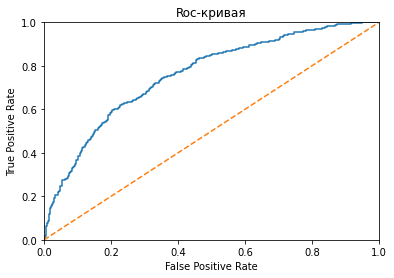

CPU times: user 340 ms, sys: 181 ms, total: 520 ms
Wall time: 536 ms


In [13]:
%%time

#обучаем модель
model = LogisticRegression(random_state=12345)
model.fit(features_train, target_train)
prediction_valid = model.predict(features_valid)
#исследуем метрики
f1 = f1_score(target_valid, prediction_valid)
print(f'Значение F1 равно {f1}')
probabilities = model.predict_proba(features_valid)
probabilities_one_valid = probabilities[:,1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'AUC-ROC модели: {auc_roc}')

frp, trp, thresholds = roc_curve(target_valid,probabilities_one_valid)
plt.figure()
plt.plot(frp, trp)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc-кривая')
plt.plot([0,1], [0,1], linestyle='--')
plt.show()

### Вывод

Результаты моделей на несбалансированных данных:
* Лучший результат показала модель случайного леса с 11 деревьями и глубиной 10: F1 = 0.5925, AUC-ROC = 0.8482.
* Модель решающего дерева при глубине 6 имела F1 = 0.5696 и AUC-ROC = 0.8165
* Логистическая регрессия показала худший результат: F1 = 0.3311, AUC-ROC = 0.7588.

## Борьба с дисбалансом

### Увеличение выборки

In [14]:
#создаем функцию для увеличения числа положительных ответов
def upsample(features,target,repeat):
    features_zeros = features[target==0]
    features_ones = features[target==1]
    target_zeros = target[target==0]
    target_ones = target[target==1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones]*repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones]*repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled


In [15]:
#получаем новые выборки и проверяем их размер
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
print(features_upsampled[target==0].shape)
print(features_upsampled[target==1].shape)
print(target_upsampled[target==0].shape)
print(target_upsampled[target==1].shape)

(4804, 11)
(4784, 11)
(4804,)
(4784,)


#### Модель решающего дерева

In [16]:
best_f1 = 0
best_depth = 0
best_model = None
for depth in range (1,11,1):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_upsampled, target_upsampled)
    prediction_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, prediction_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_depth = depth
        best_model = model
probabilities = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities[:,1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'Максимальное значение F1 равно {best_f1} при глубине {best_depth}')

Максимальное значение F1 равно 0.5963791267305644 при глубине 5


Лучшее значение F1 равно 0.5963791267305644 при глубине 5
AUC-ROC лучшей модели: 0.8310244134068074


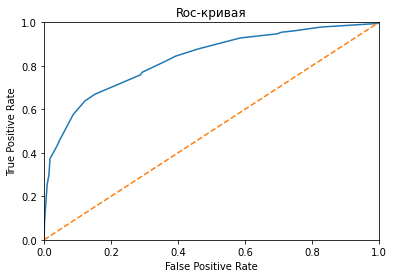

CPU times: user 101 ms, sys: 20.1 ms, total: 121 ms
Wall time: 127 ms


In [17]:
%%time

model = DecisionTreeClassifier(max_depth=5, random_state=12345)
model.fit(features_upsampled, target_upsampled)
prediction_valid = model.predict(features_valid)  
f1 = f1_score(target_valid, prediction_valid)
print(f'Лучшее значение F1 равно {f1} при глубине 5')
probabilities = model.predict_proba(features_valid)
probabilities_one_valid = probabilities[:,1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'AUC-ROC лучшей модели: {auc_roc}')

frp, trp, thresholds = roc_curve(target_valid,probabilities_one_valid)
plt.figure()
plt.plot(frp, trp)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc-кривая')
plt.plot([0,1], [0,1], linestyle='--')
plt.show()

#### Модель случайного леса 

In [18]:
best_model = None
best_f1 = 0
best_est = 0
for depth in range (1,11,1):
     for est in range(1,81,1):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345)
        model.fit(features_upsampled, target_upsampled)
        prediction_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, prediction_valid)
        if f1 > best_f1:
            best_f1 = f1
            best_est = est
            best_depth = depth
            best_model = model
print(f'Лучшее значение F1 равно {best_f1} при количестве деревьев {best_est} и глубине {best_depth}')
probabilities = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities[:,1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'AUC-ROC лучшей модели: {auc_roc}')

Лучшее значение F1 равно 0.6312433581296492 при количестве деревьев 67 и глубине 9
AUC-ROC лучшей модели: 0.8527619329901586


 Значение F1 равно 0.6312433581296492 при количестве деревьев 67 и глубине 9
AUC-ROC модели: 0.8527619329901586


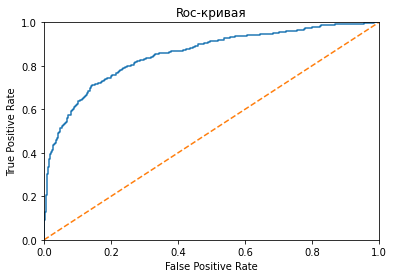

CPU times: user 588 ms, sys: 4 ms, total: 592 ms
Wall time: 1.2 s


In [19]:
%%time

model = RandomForestClassifier(n_estimators=67, max_depth=9, random_state=12345)
model.fit(features_upsampled, target_upsampled)
prediction_valid = model.predict(features_valid)
f1 = f1_score(target_valid, prediction_valid)
print(f' Значение F1 равно {f1} при количестве деревьев 67 и глубине 9')
probabilities = model.predict_proba(features_valid)
probabilities_one_valid = probabilities[:,1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'AUC-ROC модели: {auc_roc}')

frp, trp, thresholds = roc_curve(target_valid,probabilities_one_valid)
plt.figure()
plt.plot(frp, trp)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc-кривая')
plt.plot([0,1], [0,1], linestyle='--')
plt.show()

#### Модель логистической регрессии

Значение F1 равно 0.4888507718696398
AUC-ROC модели: 0.7636206364664678


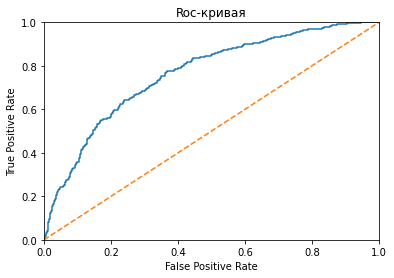

CPU times: user 444 ms, sys: 320 ms, total: 764 ms
Wall time: 984 ms


In [20]:
%%time

model = LogisticRegression(random_state=12345)
model.fit(features_upsampled, target_upsampled)
prediction_valid = model.predict(features_valid)
f1 = f1_score(target_valid, prediction_valid)
print(f'Значение F1 равно {f1}')
probabilities = model.predict_proba(features_valid)
probabilities_one_valid = probabilities[:,1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'AUC-ROC модели: {auc_roc}')

frp, trp, thresholds = roc_curve(target_valid,probabilities_one_valid)
plt.figure()
plt.plot(frp, trp)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc-кривая')
plt.plot([0,1], [0,1], linestyle='--')
plt.show()

Сбалансировали данные с помощью увеличения выборки. Получили следующие результаты:
* Лучший результат у модели случайного леса при 57 деревьях и глубине 11: F1 = 0.6263, AUC-ROC = 0.8479.
* Модель решающего дерева показала лучший результат при глубине 5: F1 = 0.5964, AUC-ROC = 0.7837.
* Модель логистической регрессии показала худший результат: F1 = 0.4889, AUC-ROC = 0.7636.

### Взвешивание классов

#### Модель решающего дерева

In [21]:
best_f1 = 0
best_depth = 0
best_model = None
for depth in range (1,11,1):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345, class_weight='balanced')
    model.fit(features_train, target_train)
    prediction_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, prediction_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_depth = depth
        best_model = model
probabilities = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities[:,1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'Максимальное значение F1 равно {best_f1} при глубине {best_depth}')

Максимальное значение F1 равно 0.5963791267305644 при глубине 5


F1 равно 0.5963791267305644 при глубине 5
AUC-ROC модели: 0.8310244134068074


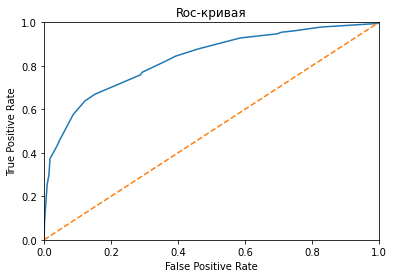

CPU times: user 118 ms, sys: 7.99 ms, total: 126 ms
Wall time: 274 ms


In [22]:
%%time

model = DecisionTreeClassifier(max_depth=5, random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)
prediction_valid = model.predict(features_valid)  
f1 = f1_score(target_valid, prediction_valid)
print(f'F1 равно {f1} при глубине 5')
probabilities = model.predict_proba(features_valid)
probabilities_one_valid = probabilities[:,1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'AUC-ROC модели: {auc_roc}')

frp, trp, thresholds = roc_curve(target_valid,probabilities_one_valid)
plt.figure()
plt.plot(frp, trp)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc-кривая')
plt.plot([0,1], [0,1], linestyle='--')
plt.show()

#### Модель случайного леса

In [23]:
best_model = None
best_f1 = 0
best_est = 0
for depth in range (1,11,1):
     for est in range(1,81,1):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345, class_weight='balanced')
        model.fit(features_train, target_train)
        prediction_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, prediction_valid)
        if f1 > best_f1:
            best_f1 = f1
            best_est = est
            best_depth = depth
            best_model = model
print(f'Лучшее значение F1 равно {best_f1} при количестве деревьев {best_est} и глубине {best_depth}')
probabilities = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities[:,1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'AUC-ROC лучшей модели: {auc_roc}')

Лучшее значение F1 равно 0.6292906178489703 при количестве деревьев 60 и глубине 9
AUC-ROC лучшей модели: 0.8539278606814704


F1 равно 0.6292906178489703 при 60 деревьях и глубине 9
AUC-ROC модели: 0.8539278606814704


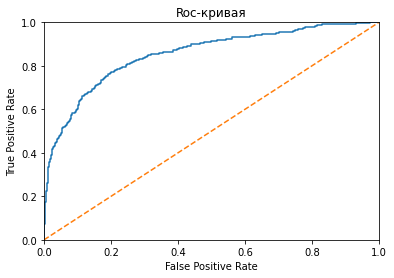

In [24]:
model = RandomForestClassifier(n_estimators=60, max_depth=9, random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)
prediction_valid = model.predict(features_valid)
f1 = f1_score(target_valid, prediction_valid)
print(f'F1 равно {f1} при 60 деревьях и глубине 9')
probabilities = model.predict_proba(features_valid)
probabilities_one_valid = probabilities[:,1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'AUC-ROC модели: {auc_roc}')

frp, trp, thresholds = roc_curve(target_valid,probabilities_one_valid)
plt.figure()
plt.plot(frp, trp)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc-кривая')
plt.plot([0,1], [0,1], linestyle='--')
plt.show()

#### Модель логистической регрессии

Значение F1 равно 0.4888507718696398
AUC-ROC модели: 0.7636811255814515


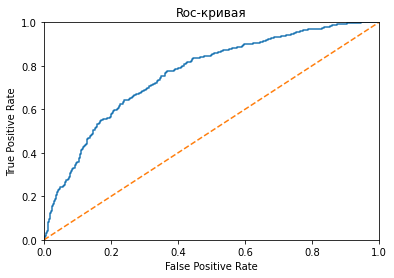

CPU times: user 259 ms, sys: 164 ms, total: 424 ms
Wall time: 428 ms


In [25]:
%%time

model = LogisticRegression(random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)
prediction_valid = model.predict(features_valid)
f1 = f1_score(target_valid, prediction_valid)
print(f'Значение F1 равно {f1}')
probabilities = model.predict_proba(features_valid)
probabilities_one_valid = probabilities[:,1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'AUC-ROC модели: {auc_roc}')

frp, trp, thresholds = roc_curve(target_valid,probabilities_one_valid)
plt.figure()
plt.plot(frp, trp)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc-кривая')
plt.plot([0,1], [0,1], linestyle='--')
plt.show()

Сбалансировали данные с помощью взвешивания классов. Получили следующие результаты:
* Модель случайного леса с 60 деревьями и глубиной 9 показала лучшие результаты: F1 = 0.6293, AUC-ROC = 0.8539.
* Модель решающего дерева при глубине 5 показала F1 = 0.5964, AUC-ROC = 0.8310.
* Модель логистической регрессии показала худший результат: F1 = 0.4889, AUC-ROC = 0.7637.

### Уменьшение выборки

In [26]:
#создаем функцию для уменьшения выборки
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    return features_downsampled, target_downsampled

#получаем новые выборки и проверяем их размер
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)
print(features_downsampled[target==0].shape)
print(features_downsampled[target==1].shape)
print(target_downsampled[target==0].shape)
print(target_downsampled[target==1].shape)


(1201, 11)
(1196, 11)
(1201,)
(1196,)


#### Модель решающего дерева

In [27]:
best_f1 = 0
best_depth = 0
best_model = None
for depth in range (1,11,1):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_downsampled, target_downsampled)
    prediction_valid = model.predict(features_valid)
    f1 = f1_score(target_valid, prediction_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_depth = depth
        best_model = model
probabilities = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities[:,1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'Максимальное значение F1 равно {best_f1} при глубине {best_depth}')

Максимальное значение F1 равно 0.5943204868154158 при глубине 5


F1 равно 0.5943204868154158 при глубине 5
AUC-ROC лучшей модели: 0.8241029464247908


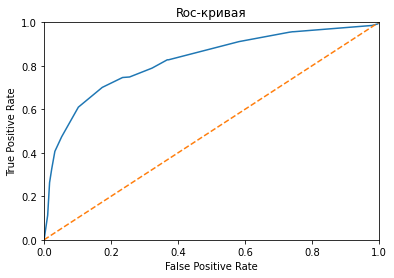

CPU times: user 101 ms, sys: 12 ms, total: 113 ms
Wall time: 119 ms


In [28]:
%%time

model = DecisionTreeClassifier(max_depth=5, random_state=12345)
model.fit(features_downsampled, target_downsampled)
prediction_valid = model.predict(features_valid)  
f1 = f1_score(target_valid, prediction_valid)
print(f'F1 равно {f1} при глубине 5')
probabilities = model.predict_proba(features_valid)
probabilities_one_valid = probabilities[:,1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'AUC-ROC лучшей модели: {auc_roc}')

frp, trp, thresholds = roc_curve(target_valid,probabilities_one_valid)
plt.figure()
plt.plot(frp, trp)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc-кривая')
plt.plot([0,1], [0,1], linestyle='--')
plt.show()

#### Модель случайного леса

In [29]:
best_model = None
best_f1 = 0
best_est = 0
for depth in range (1,11,1):
     for est in range(1,81,1):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345)
        model.fit(features_downsampled, target_downsampled)
        prediction_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, prediction_valid)
        if f1 > best_f1:
            best_f1 = f1
            best_est = est
            best_depth = depth
            best_model = model
print(f'Лучшее значение F1 равно {best_f1} при количестве деревьев {best_est} и глубине {best_depth}')
probabilities = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities[:,1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'AUC-ROC лучшей модели: {auc_roc}')

Лучшее значение F1 равно 0.6092184368737475 при количестве деревьев 10 и глубине 4
AUC-ROC лучшей модели: 0.8354975834598564


 Значение F1 равно 0.6092184368737475 при количестве деревьев 10 и глубине 4
AUC-ROC модели: 0.8354975834598564


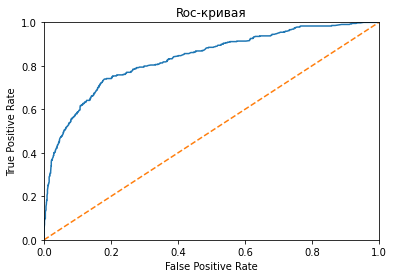

CPU times: user 134 ms, sys: 8.02 ms, total: 142 ms
Wall time: 148 ms


In [30]:
%%time

model = RandomForestClassifier(n_estimators=10, max_depth=4, random_state=12345)
model.fit(features_downsampled, target_downsampled)
prediction_valid = model.predict(features_valid)
f1 = f1_score(target_valid, prediction_valid)
print(f' Значение F1 равно {f1} при количестве деревьев 10 и глубине 4')
probabilities = model.predict_proba(features_valid)
probabilities_one_valid = probabilities[:,1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'AUC-ROC модели: {auc_roc}')

frp, trp, thresholds = roc_curve(target_valid,probabilities_one_valid)
plt.figure()
plt.plot(frp, trp)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc-кривая')
plt.plot([0,1], [0,1], linestyle='--')
plt.show()

#### Модель логистической регрессии

Значение F1 равно 0.48406546080964685
AUC-ROC модели: 0.7622203134545938


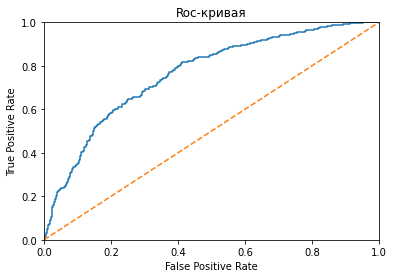

CPU times: user 244 ms, sys: 152 ms, total: 396 ms
Wall time: 403 ms


In [31]:
%%time

model = LogisticRegression(random_state=12345)
model.fit(features_downsampled, target_downsampled)
prediction_valid = model.predict(features_valid)
f1 = f1_score(target_valid, prediction_valid)
print(f'Значение F1 равно {f1}')
probabilities = model.predict_proba(features_valid)
probabilities_one_valid = probabilities[:,1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(f'AUC-ROC модели: {auc_roc}')

frp, trp, thresholds = roc_curve(target_valid,probabilities_one_valid)
plt.figure()
plt.plot(frp, trp)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc-кривая')
plt.plot([0,1], [0,1], linestyle='--')
plt.show()

При балансировке данных с помощью уменьшения выборки получили следующие результаты:
* Лучший результат показала модель случайного леса при 10 деревьях и глубине 4: F1 = 0.6092, AUC-ROC = 0.8355.
* Модель решающего дерева при глубине 5 показала F1 = 0.5943, AUC-ROC = 0.8241.
* Модель логистической регрессии показала худший результат: F1 = 0.4841, AUC-ROC = 0.7622.

### Вывод

Провели балансировку обучающих данных следующими способами: увеличением выборки, взвешиванием классов, уменьшением выборки.
На сбалансированных данных подбирали и обучали модели решающего дерева, случайного леса и логистической регрессии.

**Лучшие значения метрик F1 и AUC-ROC показала модель случайного леса (67 деревьев, глубина 9) при увеличении выборки: F1 = 0.6312, AUC-ROC = 0.8528**


## Тестирование модели

Значение F1 равно 0.604989604989605
AUC-ROC модели: 0.8532854823549516


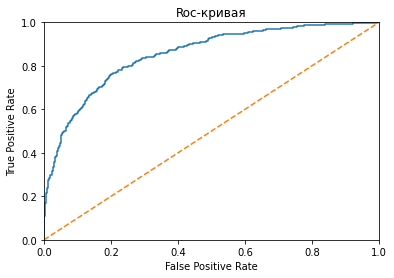

CPU times: user 570 ms, sys: 4.02 ms, total: 574 ms
Wall time: 580 ms


In [32]:
%%time

model = RandomForestClassifier(n_estimators=67, max_depth=9, random_state=12345)
model.fit(features_upsampled, target_upsampled)
prediction_test = model.predict(features_test)
f1 = f1_score(target_test, prediction_test)
print(f'Значение F1 равно {f1}')
probabilities = model.predict_proba(features_test)
probabilities_one_test = probabilities[:,1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(f'AUC-ROC модели: {auc_roc}')

frp, trp, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure()
plt.plot(frp, trp)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc-кривая')
plt.plot([0,1], [0,1], linestyle='--')
plt.show()

По сравнению с валидационной выборкой, значение F1 упало, но незначительно. Значение AUC-ROC слегка выросло. Следовательно, модель не переобучилась и справляется с поставленной задачей.